0_predict.png


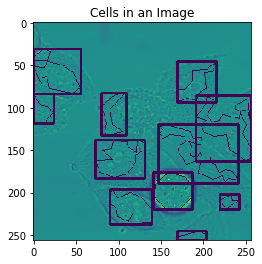

<Figure size 432x288 with 0 Axes>

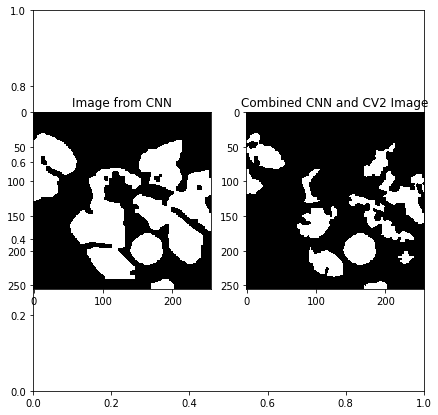

1_predict.png


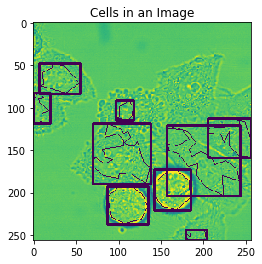

<Figure size 432x288 with 0 Axes>

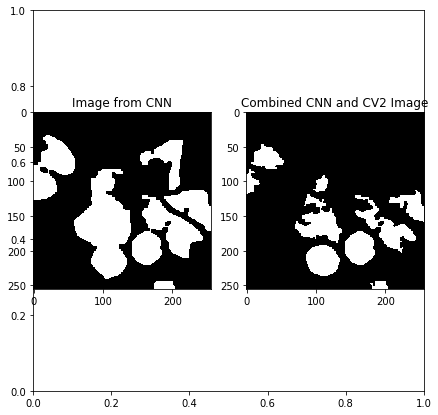

2_predict.png


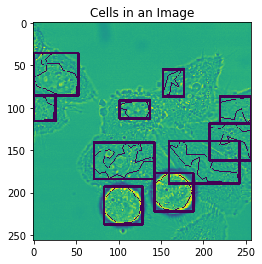

<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [7]:
### Trying different methods to segment the DIC-C2DH-HeLa dataset ###
import imutils
import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random as rng

from scipy import ndimage as ndi
from skimage import morphology
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import MeanShift
from skimage.filters import threshold_otsu
from skimage.filters import gaussian
from skimage.segmentation import active_contour

cap = cv2.VideoCapture("Sequences/DIC-C2DH-HeLa/Sequence 3/t%03d.tif", cv2.CAP_IMAGES)
old = np.ones((512, 512))
counter = 0

while cap.isOpened():
    ret, frame = cap.read()
    
    ### Kernel for morphological tranformation ###
    kernel = np.ones((5,5),np.uint8)
    
    ### Blurring to smooth the insides of the cells ###
    ### Choose the appropriate blur ###
    ## LOOK AT FILTER 2D
    cl = cv2.equalizeHist(frame)
    cl = cv2.medianBlur(cl, 17)
    cl = cv2.fastNlMeansDenoising(cl, None, 9, 19, 19)
    
    ### Applying the proper threshold to the h-dome image to obtain a binary image ###
    ### Choose the appropriate threshold function ###
    thresh = cv2.adaptiveThreshold(cl,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,191,3)
    thresh = cv2.bitwise_not(thresh)
    
    ### Binary image manipulation to remove artifacts ###
    imglab = morphology.label(thresh)
    cleaned = morphology.remove_small_objects(imglab, min_size=800, connectivity=1)
    img3 = np.zeros((cleaned.shape))
    img3[cleaned > 0] = 255 
    img3= np.uint8(img3)
    ### Assigning the final image to 'thresh' variable ###
    thresh = cv2.bitwise_not(img3)
    
    ### Removing artifacts from the threshold image ###
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    
    ### Opening the image obtained from the neural net to use as a mask ###
    ### The neural net identifies the outside borders of the cell sequence and image manipulation identifies ###
    ### the inner borders. Using the neural net image as a masking image allows for seperation of cells ###
    im = Image.open("Sequences/DIC-C2DH-HeLa/Sequence 3 Results/%d_predict.png"%counter)
    print("%d_predict.png"%counter)
    counter += 1
    im = np.array(im)
    ### Eroding the border for better final image ###
    im = cv2.erode(im,kernel,iterations = 1)
    ### Opening and closing to remove artifacts ###
    im = cv2.morphologyEx(im, cv2.MORPH_OPEN, kernel)
    im = cv2.morphologyEx(im, cv2.MORPH_CLOSE, kernel)
    
    ### Resizing the threshold image to the same size as the image obtained from the neural net ###
    thresh = cv2.resize(thresh, im.shape[1::-1])
    ### Using the neural net image as a mask ###
    dst = cv2.bitwise_and(im, thresh)
    ### Removing the small objects from the image ###
    imglab = morphology.label(dst)
    cleaned = morphology.remove_small_objects(imglab, min_size=200, connectivity=1)
    img3 = np.zeros((cleaned.shape))
    img3[cleaned > 0] = 255 
    dst = np.uint8(img3)
    
    ### Resizing the initial unmodified image so that the contours can be displayed on a plot ###
    resized = cv2.resize(frame, im.shape[1::-1])
    im2, contours, hierarchy = cv2.findContours(dst, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    ### Removing contours inside contours because a cell cannot be inside another cell ###
    cells = []
    for i, c in enumerate(contours):
        if hierarchy[0][i][3] == -1:
            cells.append(c)
    
    
    ### Obtaining the coordinates for the bounding box ###
    contours_poly = [None]*len(cells)
    boundRect = [None]*len(cells)
    for i, c in enumerate(cells):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
    
    ### Drawing the contours and the boundin box ###
    ### Comment out the 'cv2.drawContours' to not draw the cell contours ###
    for i in range(len(cells)):
        color = (0, 255, 0)
        final = cv2.drawContours(resized, contours_poly, i, color)
        final = cv2.rectangle(resized, (int(boundRect[i][0]), int(boundRect[i][1])), \
          (int(boundRect[i][0]+boundRect[i][2]), int(boundRect[i][1]+boundRect[i][3])), color, 2)
    
    ### Uncomment the 'gray' section to obtain a black/white image ###
    plt.imshow(final)#, cmap=plt.get_cmap("gray"))
    plt.title('Cells in an Image')
    plt.show()
    
    ### Plotting the obtained results ##
    fig = plt.figure()
    fig, ax = plt.subplots(figsize=(7, 7))
    fig.add_subplot(1, 2, 1)
    plt.imshow(im, cmap=plt.get_cmap("gray"))
    plt.title('Image from CNN')
    fig.add_subplot(1, 2, 2)
    plt.imshow(dst, cmap=plt.get_cmap("gray"))
    plt.title('Combined CNN and CV2 Image')
    plt.show()